In [4]:
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import csv

In [5]:
data_labeled = np.loadtxt('./training_data.txt', skiprows=1)
X = data_labeled[:, 1:]
Y = data_labeled[:, 0]

N, D = X.shape

with open('training_data.txt') as f:
    reader = csv.reader(f, delimiter=" ")
    labels = next(reader)
labels = labels[1:]

In [6]:
label_weights = pd.read_csv("./Logistic_L1_weights_229.txt", delimiter="\t")
label_weights.head()

,labels,weights
0,thi,-0.072667
1,book,0.026721
2,wa,-0.141398
3,one,0.075002
4,read,0.220413


## First, some more exploratory data analysis

In [7]:
wordsums = np.sum(X, axis=0)
reviewsums = np.sum(X, axis=1)

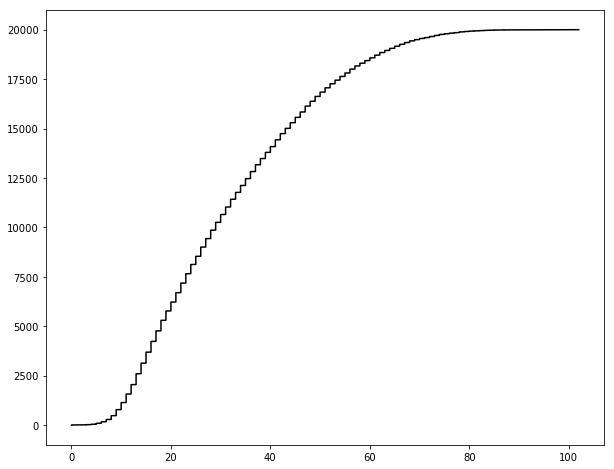

In [16]:
plt.figure(figsize=(10,8))
plt.plot(sorted(reviewsums), range(N), c='k')

In [22]:
print(min(reviewsums), max(reviewsums))
print(np.sum(np.less_equal(reviewsums, 0)))
print(np.sum(np.less_equal(reviewsums, 5)))
print(np.mean(reviewsums))
print(np.median(reviewsums))

0.0 102.0
4
88
31.965
29.0


In [30]:
print(min(wordsums), max(wordsums))
print(np.sum(np.less_equal(wordsums, 120)))
print(np.sum(np.less_equal(wordsums, 130)))
print(np.mean(wordsums))
print(np.mean(wordsums[1:]))
print(np.median(wordsums))

120.0 30565.0
1
5
639.3
609.344344344
309.0


In [38]:
wordOccurrence = np.sum(np.greater(X, 0), axis=0)
wordMultiplicity = wordsums / wordOccurrence

reviewOccurrence = np.sum(np.greater(X, 0), axis=1)

reviewDiversity = np.zeros(N)
for i in range(N):
    if reviewsums[i] == 0: # iff review occurrence = 0.
        reviewDiversity[i] = 0  # 0/0 appeared. Avoid "RuntimeWarning: invalid value encountered in true_divide"
    else:
        reviewDiversity[i] = reviewsums[i] / reviewOccurrence[i]

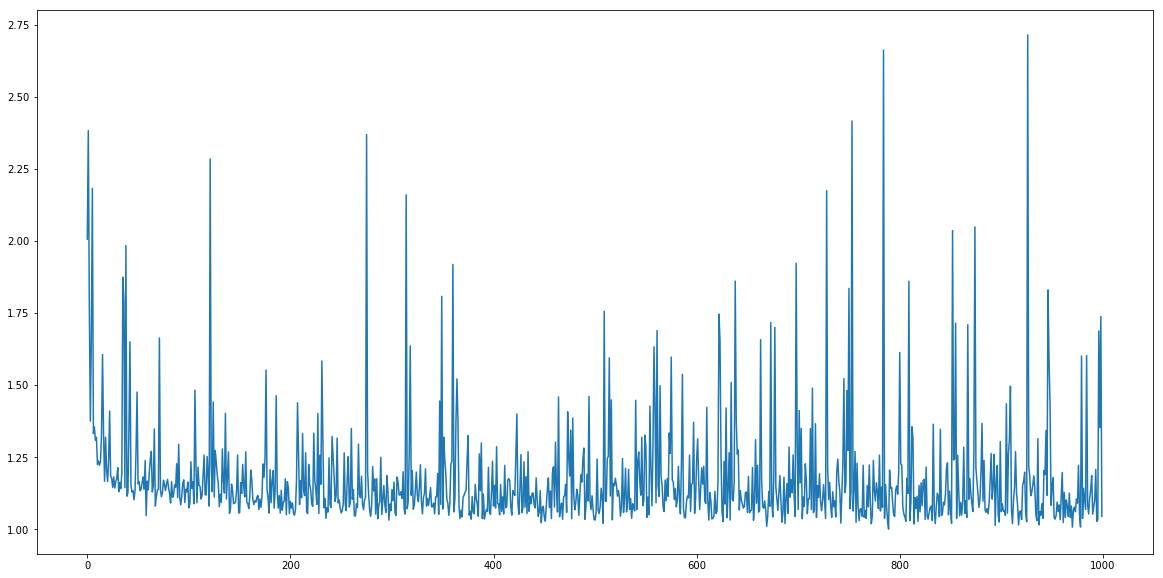

In [34]:
plt.figure(figsize=(20,10))
plt.plot(range(D), wordMultiplicity)

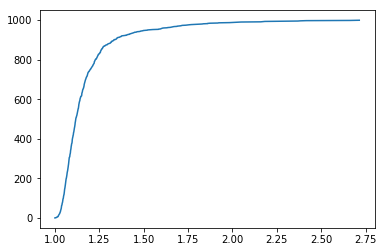

In [35]:
plt.plot(sorted(wordMultiplicity), range(D))

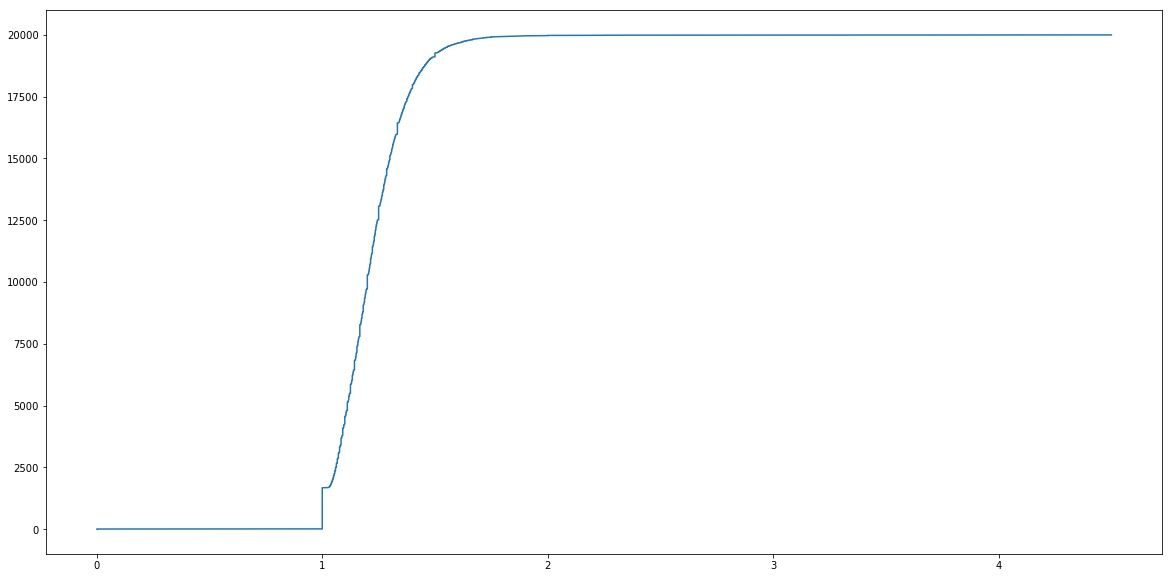

In [39]:
plt.figure(figsize=(20,10))
plt.plot(sorted(reviewDiversity), range(N))

## Now we will assess different feature selection hyperparams

In [73]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score

def NBayesCrossVal(whichweights, X_orig, Y_orig, laplace=1, kfold=5, modeltype='multinomial'):
    
    N, D = X_orig.shape
    nhypers = whichweights.shape[0] # nhypers X nweights
    models = []
    val_scores = []

    for hyper in range(nhypers): 
        theseweights = whichweights[hyper, :]
        X = X_orig[:, theseweights.astype('bool')]
        if modeltype == 'bernoulli':
            model = BernoulliNB(alpha=1.0, fit_prior=True)
        elif modeltype == 'multinomial':
            model = MultinomialNB(alpha=1.0, fit_prior=True)
        scores = cross_val_score(model, X, Y, cv=kfold)
        models.append(model)
        val_scores.append(scores)
        
    val_scores = np.array(val_scores)
    mean_val_scores = np.mean(val_scores, axis=1)
    hyper_best_i = np.argmax(mean_val_scores)
#     c_best = Cs[c_best_i]
    print(hyper_best_i, mean_val_scores[hyper_best_i]) #c_best,
#     print(Cs[c_best_i-1], Cs[c_best_i+1])
    
    return val_scores, mean_val_scores, hyper_best_i, models

In [184]:
# Take weights above a threshold T, especially a threshold of 0.

abs_weights = np.absolute(label_weights.weights)

nhypers = 20 # Bayes is fast
w_max = np.amax(abs_weights)
Ts = np.linspace(0, w_max, nhypers)[:-1] #Don't want there to be no columns.
Ts = np.insert(Ts, 0, -1, axis=0)

whichweights = np.zeros((nhypers, D))
for i, T in enumerate(Ts):
    whichweights[i, :] = abs_weights > T #label_weights.weights > T
    


val_scores, mean_val_scores, hyper_best_i, models = NBayesCrossVal(whichweights, X, Y, 1, 5, 'multinomial')
# plt.plot(Ts, mean_val_scores)
# models = []
# valscores = []

# for T in Ts:
#     whichweights = label_weights.weights > T #
#     model, scores = NBayesCrossVal(whichweights, X, Y, 1, 5, 'multinomial')
#     models.append(model)
#     valscores.append(scores)


2 0.852999130291


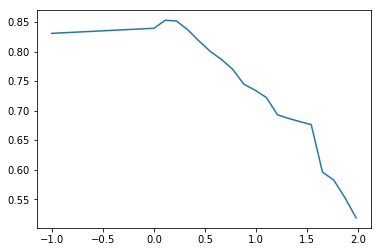

In [185]:
plt.plot(Ts, mean_val_scores)

In [186]:
tfifd = TfidfTransformer(norm=None)
X_tfifd = tfifd.fit_transform(X)
val_scores, mean_val_scores, hyper_best_i, models = NBayesCrossVal(whichweights, X_tfifd, Y, 1, 5, 'multinomial')

3 0.846099592387


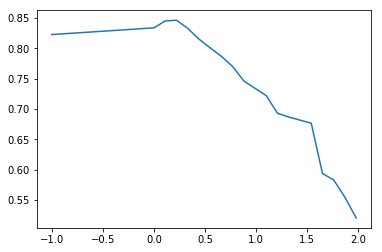

In [187]:
plt.plot(Ts, mean_val_scores)

In [132]:
test = np.array([0, 1, 2, 3])
test2 = np.insert(test, 0, 100)
print(test)
print(test2)

[0 1 2 3]
[100   0   1   2   3]


In [197]:
# Take the top Q percentile weights.

nhypers = 50
Qs = np.linspace(0, 99, nhypers) # 0.1% of 1000 is 1
whichweights = np.zeros((nhypers, D))

abs_weights = np.absolute(label_weights.weights)
for i, Q in enumerate(Qs):
    cutoff = np.percentile(a=abs_weights, q=Q)
    whichweights[i, :] = np.greater_equal(abs_weights, cutoff)
    


In [198]:
# sum(whichweights[0, :])
# [np.percentile(a=np.absolute(label_weights.weights), q=Q) for Q in Qs]
# sum(whichweights[29, :])

In [199]:
val_scores, mean_val_scores, hyper_best_i, models = NBayesCrossVal(whichweights, X_tfifd, Y, 1, 5, 'multinomial')

30 0.850199792612


0.177326448528


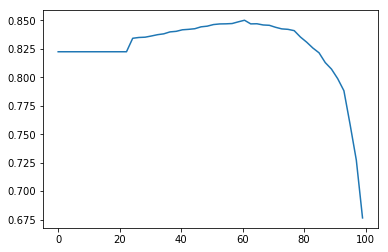

In [195]:
percentiles = [np.percentile(a=np.absolute(label_weights.weights), q=Q) for Q in Qs]
print(percentiles[hyper_best_i])
plt.plot(Qs, mean_val_scores)

32 0.8539992428
0.199586335165


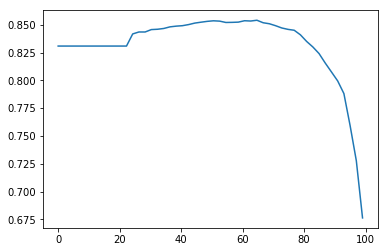

In [200]:
val_scores, mean_val_scores, hyper_best_i, models = NBayesCrossVal(whichweights, X, Y, 1, 5, 'multinomial')
print(percentiles[hyper_best_i])
plt.plot(Qs, mean_val_scores)

In [201]:
nhypers = 50
Qs = np.linspace(50, 70, nhypers) # 0.1% of 1000 is 1
whichweights = np.zeros((nhypers, D))
abs_weights = np.absolute(label_weights.weights)
for i, Q in enumerate(Qs):
    cutoff = np.percentile(a=abs_weights, q=Q)
    whichweights[i, :] = np.greater_equal(abs_weights, cutoff)

percentiles = [np.percentile(a=np.absolute(label_weights.weights), q=Q) for Q in Qs]

33 0.854549105309
0.19118380381


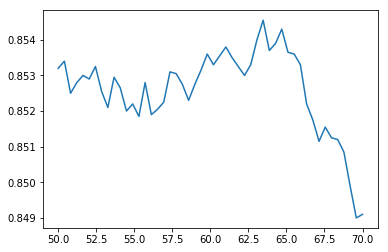

In [202]:
val_scores, mean_val_scores, hyper_best_i, models = NBayesCrossVal(whichweights, X, Y, 1, 5, 'multinomial')
print(percentiles[hyper_best_i])
plt.plot(Qs, mean_val_scores)

In [216]:
bestweights = whichweights[33, :] #models[33] # No, all the models are the same!
bestmodel = models[0] # All the models are the same!
bestmatrix = X[:, bestweights.astype('bool')]
bestmodel.fit(bestmatrix, Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [217]:
hypoth_best = bestmodel.predict(bestmatrix)

In [218]:
accuracy_best = np.sum(np.equal(Y, hypoth_best)) / N
print(accuracy_best)

0.8566
